# ROB311 - SVM Digit Recognition
***Brice Tayart***

4th Lab assignment for the Machine learning for Robotics course at ENSTA by Prof. Adriana Tapus.

---
   **Introduction**  
   Today, you will use **Support Vector Machines** and **Python** in order to implement a **digit recognition** algorithm. The database used to train and test your algorithm is the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), containing grayscale (8-bit), 28x28 pixels images of hand written digits. This is one of the reference digit recognition datasets in the world and, as you can see,
state-of-the-art SVM algorithms can achieve error rates as low as 0.56 to 1.4 %.

   **Files**  
   The two .csv files containing the MNIST dataset (both training and test set) [can be downloaded here](https://www.kaggle.com/oddrationale/mnist-in-csv) (using the Download button). Each of the two files contains 785 columns, the first column corresponding to the **label** of each sample (a digit from 0 to 9), while the other 784 columns contain the **colour intensity value** (8-bit, 0 to 255) for each of the pixels of a 28x28 image.
   
   The training set (*mnist_train.csv*) contains 60.000 samples, while the test set (*mnist_test.csv*) contains 10.000 samples.

   **Objectives**  
   Implement the digit recognition algorithm using Support Vector Machines trained on the MNIST hand written digit dataset contained in the mnist_train.csv file. Then, test your algorithm on the provided mnist_test.csv file.
   
   You will have to compute:
- **the overall detection accuracy** (the percentage of correctly recognised digits from
the test set)
- **a confusion matrix** (of size 10x10)

Both the detection accuracy and confusion matrix can be simply displayed in a terminal, but feel free to use any graphic libraries you want to display them.

---

The plan for the assignment is as follows :
- load data
- dimensionality reduction
- assess several classifiers on a small training set
- pick the most promising and adust its parameters on the full training set
- test the classifier on the test set

### Load the datasets

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import svm
from sklearn import decomposition

In [2]:
#Set-up the path
inputDir = "/media/btayart/Disque Dur 1TB/DATA/ROB311_TP3/"

file_X_test = "t10k-images.idx3-ubyte"
file_X_train = "train-images.idx3-ubyte"
file_y_test = "t10k-labels.idx1-ubyte"
file_y_train = "train-labels.idx1-ubyte"


The binary files are read. Format detail is available on http://yann.lecun.com/exdb/mnist/
Care must be taken: 32bit integers are stored in big endian (not the native endianness of x86 achitecture).

In [3]:
#Read the binary files (see NING)
def readImagesFromFile(filename):
    f = open(filename, mode='rb')
    try:
        #check magic number (in case the file or endianness is wrong)
        magic = np.fromfile(f,dtype='>i4',count=1)
        assert magic == 2051
        
        #Read dimensions and data
        n_img = np.fromfile(f,dtype='>i4',count=1)
        rows = np.fromfile(f,dtype='>i4',count=1)
        columns = np.fromfile(f,dtype='>i4',count=1)
        n_bytes = n_img*rows*columns
        
        bulk = np.fromfile(f,dtype='uint8',count=n_bytes[0])
        
        return bulk.reshape(np.hstack((n_img,rows,columns))).astype('float')
    finally:
        f.close()
        
def readLabelsFromFile(filename):
    f = open(filename, mode='rb')
    try:
        #check magic number (in case the file or endianness is wrong)
        magic = np.fromfile(f,dtype='>i4',count=1)
        assert magic == 2049

        #Read dimensions and data
        n_img = np.fromfile(f,dtype='>i4',count=1)
        bulk = np.fromfile(f,dtype='uint8',count=n_img[0])
        
        return bulk.astype('float')
    finally:
        f.close()
     

In [4]:
#Read images as a 3D array, then vectorize the 3D array
#Scale from 0-255 to 0.0-1.0
image_train_full = readImagesFromFile(inputDir + file_X_train) / 255.0
n_train_full = image_train_full.shape[0]
X_train_full = image_train_full.reshape((n_train_full,-1))

y_train_full = readLabelsFromFile(inputDir + file_y_train)

X_test = readImagesFromFile(inputDir + file_X_test).reshape((-1,X_train_full.shape[1])) / 255.0
y_test = readLabelsFromFile(inputDir + file_y_test)


In [5]:
#Function to display images

def showImages(arr,stride=0, random_display=True, nimg=(15,15), invert=False, figsize=(15,15)):
    '''
        show random images from a grayscale image array
        (i.e. [n, height, width] ndarray)
        
        stride = pixels added between images
        nimg = number of images to show (n1,n2)
        invert = True/False to invert colors
    '''
    
    #initializations
    ishp = arr.shape

    istr = (ishp[1]+stride, ishp[2]+stride)

    nimg = np.array(nimg)
    im2show = np.zeros((nimg[0]*istr[0], nimg[1]*istr[1]))
    
    # Sample images to be displayed (if enough)
    ratio = nimg[0]*nimg[1]/ishp[0]
    if random_display and ratio<=1:
        idx=np.random.choice(ishp[0],size=nimg,replace=False)
    else:
        idx=np.arange(nimg[0]*nimg[1])%ishp[0]
        idx=idx.reshape((nimg))
        
    # Copy-paste values in im2show
    for ii in range(nimg[0]):
        for jj in range(nimg[1]):
            offset_ii = ii*istr[0]+stride//2
            offset_jj = jj*istr[1]+stride//2
            im2show[offset_ii:offset_ii+ishp[1],
                    offset_jj:offset_jj+ishp[2]] = \
                    arr[idx[ii,jj],:,:]

    #inversion (for "digits" dataset)
    if invert:
        im2show = im2show.flatten().max()-im2show
        
    #display
    plt.figure(figsize=figsize)
    plt.imshow(im2show, cmap="gray")
    plt.axis('equal');

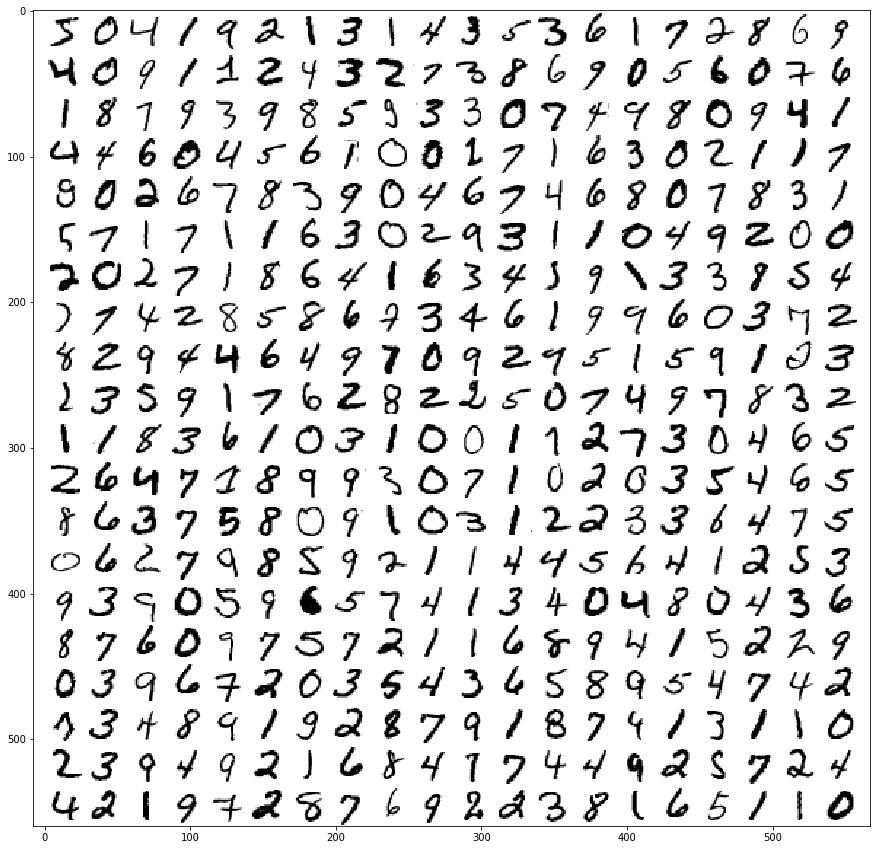

In [6]:
showImages(image_train_full,stride=0,invert=True,nimg=(20,20),random_display=False)

## Pre-processing : PCA
It seems from the image above that there is a lot of white space around each digit, i.e. some pixels are almost always zero and will not contribute to the classification. Having some pixels always equal to zero means that the original images contain less information that what 784 pixels could provide. Indeed, the image contain digits, not just rand om nois, and there must be a way to compress the information into a much smaller number of features that will be used for classification. Such compression will speed-up the process and make the classification less sensitive to noise.

One could use convolution filters for that purpose, or train an autoencoder. An easy method for dimensionality reduction is **PCA**, which will be tried here.

For each label class, the average pixel value is plot. This gives an idea about how digits look on average. We can also look at how often pixels are used to draw a given digit.

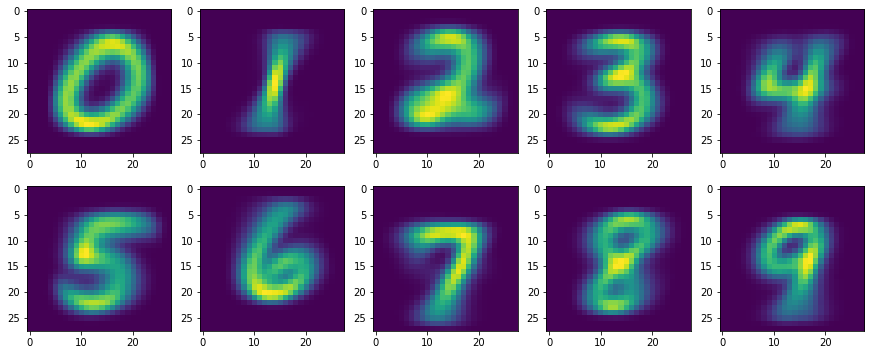

In [7]:
# Show "average" digit
plt.figure(figsize=(15,6))
for ii,label in enumerate(np.unique(y_train_full)):
    tmp = image_train_full[y_train_full==label]
    avg = np.mean(tmp,axis=0)    
    plt.subplot(2,5,ii+1);
    plt.imshow(avg);


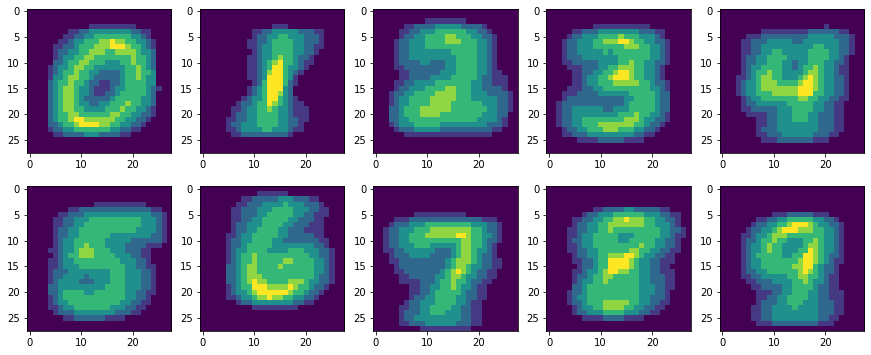

In [8]:
# Show how often pixels are used for each digit:
# Colors after each of the following thresholds:
# 1%, 5%, 20%, 50%, 80%, 90%

plt.figure(figsize=(15,6))
for ii,label in enumerate(np.unique(y_train_full)):
    tmp = image_train_full[y_train_full==label]
    freq = np.sum(tmp!=0,axis=0)/tmp.shape[0]    
    plt.subplot(2,5,ii+1);
    plt.imshow(1.0*(freq>0.01) + 1.0*(freq>0.05) + 1.0*(freq>0.20)+
               1.0*(freq>0.50) + 1.0*(freq>0.80) + 1.0*(freq>0.90),
              vmin=0, vmax=6);


We see there that digits 0 as well as the bottom part of digit 6 seem to be drawn fairly consistently : the same pixels are used more than 80% or even 90% of the time. On the other hand, digits 5 and 2 seem to be drawn with a large variability, as well as the tails of digits 6 and 9.

We also see that the pixels around the image are almost never used and could be simply removed from the classification problem.

For this work assignemnt complex pre-processing such as convolution filters will not be used, and we'll give a try to PCA. Note that, since vectors have values within the same order of magnitude (all pixels are in \[0,255\]), feature scaling is not done upfront.

In [9]:
# Run a PCA on the input features
pca = decomposition.PCA()
pca.fit(X_train_full)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

(0, 150)

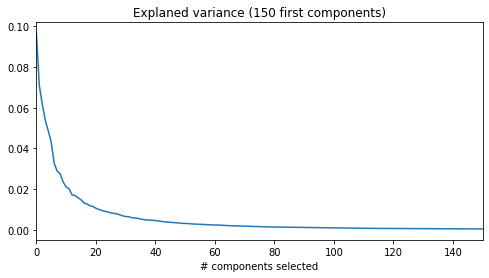

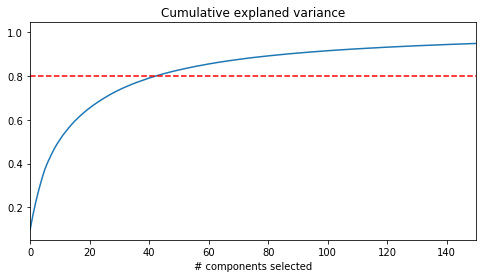

In [10]:
# Plot eigenvalues to see how many vectors should be kept
plt.figure(figsize=(8,4))
plt.plot(pca.explained_variance_ratio_)
plt.title('Explaned variance (150 first components)')
plt.xlabel('# components selected');
plt.xlim(0,150)

#Cumul
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot([0,600],[.8,.8],'--r')
plt.title('Cumulative explaned variance')
plt.xlabel('# components selected');
plt.xlim(0,150)


Let's see what happens when **40 principal components** are kept. This seems sufficient to capture most of the variance.

In [11]:
#Try to project on 40 vectors
# Run a PCA on the input features
n_kept=40

pca = decomposition.PCA(n_components=n_kept)
X_pca_full = pca.fit_transform(X_train_full)
X_pca_test = pca.transform(X_test)

Below is an display, for each digit, of the average value for the 25 first components (arranged in a 5x5 grid). Red pixels mean positive coefficient, blue pixel means negative.

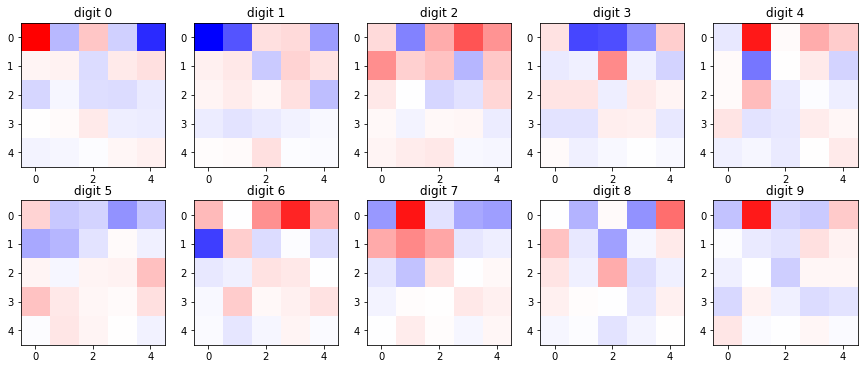

In [12]:
#show biggest 25
image_pca_full = X_pca_full[:,:25].reshape((n_train_full,5,5))
# Show "average" digits in PCA base
plt.figure(figsize=(15,6))
for ii,label in enumerate(np.unique(y_train_full)):
    tmp = image_pca_full[y_train_full==label]
    avg = np.mean(tmp,axis=0)    
    plt.subplot(2,5,ii+1);
    plt.imshow(avg, vmin=-2.5, vmax=2.5, cmap=plt.get_cmap("bwr"));
    plt.title("digit %d"%label)

We see that some PCA eigenvector look like good indicators of classification : negative top left and positive top right pixels is a predictor of digit 0; digit 6 is likewise stongly associated with pixels (3,0) positve and (0,1) negative.
On the other hand, pixel (0,1)  has a large value for digits 4, 7 and 9, and it is likely that the classifier will struggle to tell them apart.

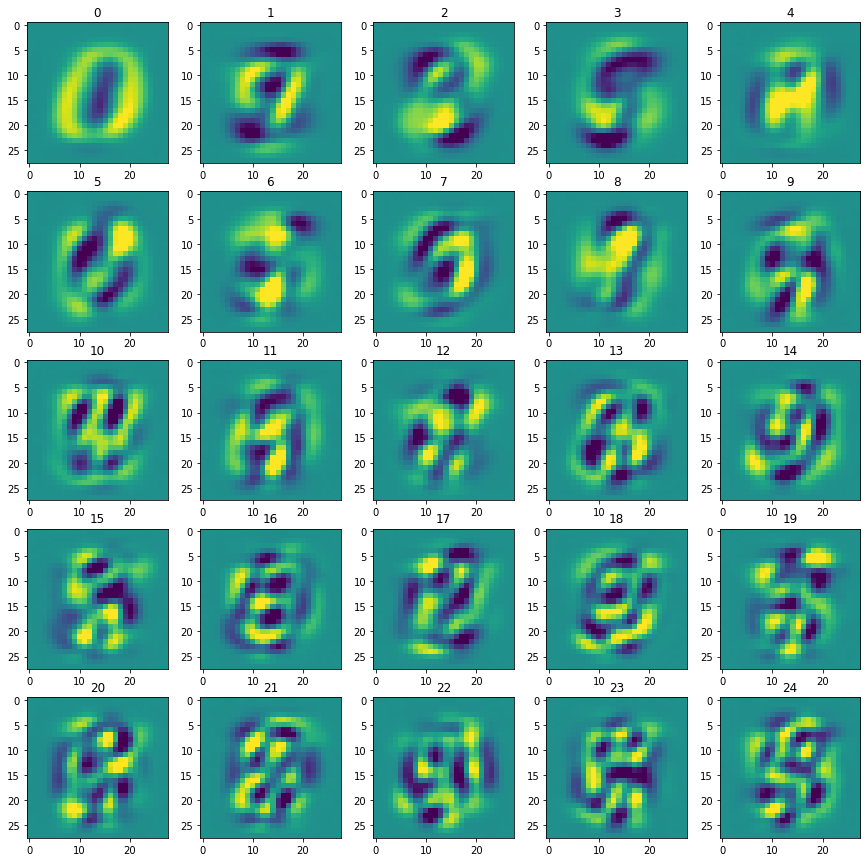

In [13]:
# Now show what these pixels mean
plt.figure(figsize=(15,15))
for ii in range(25):
    plt.subplot(5,5,ii+1);
    plt.imshow(pca.components_[ii,:].reshape(28,28),vmin=-0.1,vmax=0.1)#, cmap=plt.get_cmap("bwr"));
    plt.title("%d"%ii)

# Classification with SVM

The methodology is the following:
- several SVM will be tested on a small subsamle of the training set and evaluated on another small subsample of the crossvalidation set. This will be done on both the pre-processed and raw data. Since the subset is small, this should not take too long
- the best classifier will be picked and its parameters adjusted on the full training set (it is likely that less regularization is needed with more training data)
- the test set will be analyzed with the best classifier

### Split the dataset for training

First, a small subset of the large training set is chosen to look for promising classifiers and parameters and narrow down what should be sought by a proper cross-validation (e.g. Bootstrap or Kfold). The digits seem to be sorted randomly, so the 2000 first digits are chosen (otherwise, we may pick the samples randomly)
The last 2000 digits will be a cross-validation set.

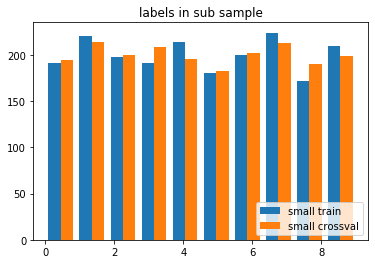

In [14]:
# Selection and flattening of the images into a vector
n = 2000
X_sub = X_train_full[:n,:]
X_pca_sub = X_pca_full[:n,:]
y_sub = y_train_full[:n]

n = 2000
X_cv = X_train_full[-n:,:]
X_pca_cv = X_pca_full[-n:,:]
y_cv = y_train_full[-n:]

# We check that the dataset still have all labels
plt.hist((y_sub,y_cv),bins=10);
plt.title("labels in sub sample");
plt.legend(('small train','small crossval'),loc="lower right");

Another split is done with much mode data, picking the 50000 first values for training and 10000 last for cross-validation

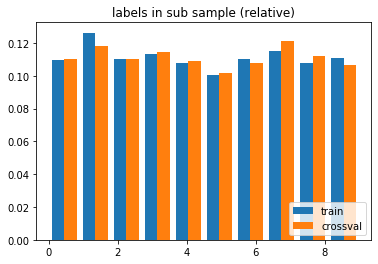

In [15]:
# Selection and flattening of the images into a vector
n = 50000
X_subbig = X_train_full[:n,:]
X_pca_subbig = X_pca_full[:n,:]
y_subbig= y_train_full[:n]

n = 10000
X_cvbig = X_train_full[-n:,:]
X_pca_cvbig = X_pca_full[-n:,:]
y_cvbig = y_train_full[-n:]

# We check that the dataset still have all labels
plt.title("labels in sub sample (relative)");
plt.hist((y_subbig,y_cvbig),bins=10,density=True);
plt.legend(('train','crossval'),loc="lower right");

## Linear SVC
### Linear SVC on the pre-procesed dataset
A quick cross validation is done to check the best regularization parameter for the linear classifier
The classifier is run several times on the first 2000 points, 

In [16]:
# Try some SVM classifiers
cValues = np.logspace(-4,1,11)

# affichage du meilleur score
def showBest(score):
    ii=np.argmax(score)
    print("best accuracy is %.3f for C=%.2e"%(score[ii],cValues[ii] ))
    return None

In [17]:
#Influence de C: entrainement sur train et évaluation sur test
testScore = np.zeros(cValues.shape)
trainScore = np.zeros(cValues.shape)


for ii,c in enumerate(cValues):
    #entrainement
    svc = svm.SVC(C=c, kernel = "linear", gamma="scale", class_weight="balanced")
    svc.fit(X_pca_sub,y_sub)
    
    #score
    trainScore[ii]= svc.score(X_pca_sub,y_sub)
    testScore[ii] = svc.score(X_pca_cv,y_cv)
   

With 40 features kept after PCA:
best accuracy is 0.938 for C=3.16e-02


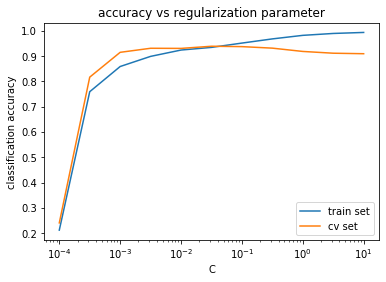

In [18]:
#affichage
plt.semilogx(cValues,trainScore,label="train set")
plt.semilogx(cValues,testScore,label="cv set")

plt.xlabel("C")
plt.ylabel("classification accuracy")
plt.title("accuracy vs regularization parameter")
plt.legend();

print("With %d features kept after PCA:"%n_kept)
showBest(testScore)

We see that the accuracy on the train set increases with less regularization, and that there is an optimal compromize between bias and variance for values of C around 0.03. This parameter will have to be decreased with the full training dataset, since a larger dataset causes less overfitting.

Surprisingly, the accuracy better on the cross-validation set than on the train set for small values of C (1e-3). This may come from the non-random selection of the sets (perhaps the train set is drawn more poorly than the test set), or from a default of stratification (i.e. the digits easier to classify come in a larger proportion in the CV set; from what we saw with the PCA, that would be more *0* and less *4* and *9*, for instance).


### RBF Kernel SVC on the pre-processed dataset

In [19]:
## CPU intensive code
## larger than necessary range taken to plot a nice graph below

svc = svm.SVC(kernel = "rbf", class_weight="balanced")
cScale = np.logspace(-2,3,11)
gammaScale = np.logspace(-2,1,7)/X_pca_sub.shape[1]

cv_dict={'C':cScale,
         'gamma':gammaScale}
gcv = model_selection.GridSearchCV(svc, cv_dict, n_jobs=-1, refit=True, cv=5, iid=True)
gcv.fit(X_pca_sub,y_sub);

In [20]:
rbf_params = gcv.best_params_
print("best estimator parameters:")
print("  gamma ratio :", rbf_params['gamma'] * X_pca_sub.shape[1])
print("  C :", rbf_params['C'])

best estimator parameters:
  gamma ratio : 1.0
  C : 1.0


The parameters are not not on the edge of the space explored, so there is no need to re-run the crossvalidation with different parameters.

In [21]:
rbf_score = gcv.best_estimator_.score(X_pca_cv, y_cv)
print("The RBF kernel best score on CV is :", rbf_score)

The RBF kernel best score on CV is : 0.961


In [22]:
#plot CV results in a figure
# first put all scores into a 2D array
gcv.cv_results_['params']
scoreGrid = np.zeros((cScale.size,gammaScale.size))

for res,par in zip(gcv.cv_results_['mean_test_score'],gcv.cv_results_['params']):
    scoreGrid[cScale==par['C'], gammaScale==par['gamma']] = res


In [23]:
# On affiche les résultats (ligne = C, colonne = gamma)
print(np.array2string(scoreGrid, precision=3))

[[0.131 0.131 0.132 0.132 0.15  0.13  0.108]
 [0.146 0.146 0.204 0.645 0.759 0.211 0.112]
 [0.113 0.208 0.761 0.845 0.872 0.536 0.115]
 [0.296 0.773 0.851 0.889 0.916 0.861 0.195]
 [0.776 0.849 0.884 0.915 0.934 0.92  0.609]
 [0.85  0.882 0.907 0.923 0.932 0.924 0.626]
 [0.88  0.898 0.907 0.923 0.931 0.924 0.626]
 [0.897 0.899 0.908 0.924 0.931 0.924 0.626]
 [0.896 0.897 0.902 0.924 0.931 0.924 0.626]
 [0.889 0.892 0.901 0.924 0.931 0.924 0.626]
 [0.886 0.882 0.901 0.924 0.931 0.924 0.626]]


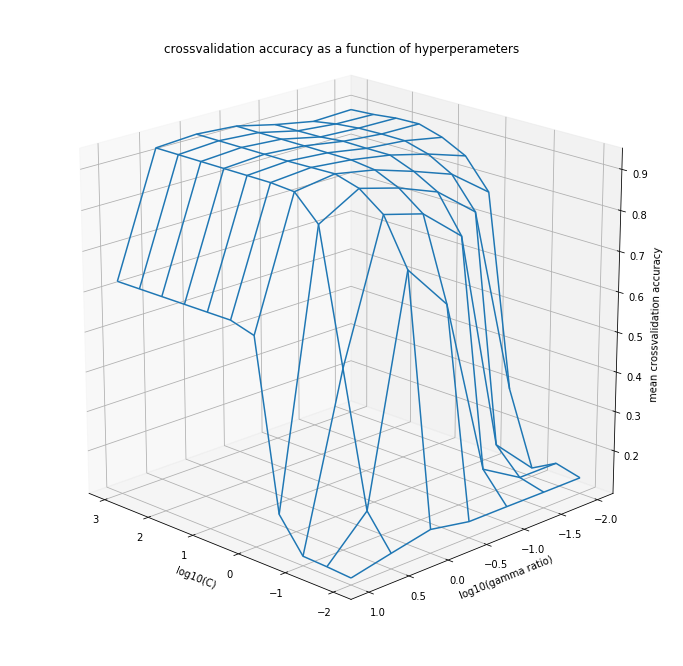

In [24]:
#Affichage de la précision sous forme de graphique:

from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')#, xscale="log", yscale="log")

ax.plot_wireframe(np.log10(cScale.reshape(-1,1)),
                  np.log10(gammaScale.reshape(1,-1) * X_pca_sub.shape[1]),
                  scoreGrid),

ax.view_init(20,135)
ax.set_xlabel("log10(C)")
ax.set_ylabel("log10(gamma ratio)")
ax.set_zlabel("mean crossvalidation accuracy");
plt.title("crossvalidation accuracy as a function of hyperperameters");


### RBF Kernel SVC on the raw dataset
The MINST dataset webpage gives a classification error under 1.5% for RBF SVC without pre-proecessing. Let's give it it a try. Since there are many more dimensions, the grid search is done on a sparser grid to save CPU time.

In [25]:
## CPU intensive code
## larger than necessary range taken to plot a nice graph below

svc = svm.SVC(kernel = "rbf", class_weight="balanced")
cScale = np.logspace(-2,3,6)
gammaScale = np.logspace(-1,2,4)/X_sub.shape[1]

cv_dict={'C':cScale,
         'gamma':gammaScale}
gcv = model_selection.GridSearchCV(svc, cv_dict, n_jobs=-1, refit=True, cv=5, iid=True)
gcv.fit(X_sub,y_sub);

In [26]:
rbf_params = gcv.best_params_
print("best estimator parameters:")
print("  gamma ratio :", rbf_params['gamma'] * X_sub.shape[1])
print("  C :", rbf_params['C'])

best estimator parameters:
  gamma ratio : 10.0
  C : 10.0


In [27]:
rbf_raw_score = gcv.best_estimator_.score(X_cv, y_cv)
print("The RBF kernel best score on CV is :", rbf_raw_score)

The RBF kernel best score on CV is : 0.9625


In [28]:
#plot CV results in a figure
# first put all scores into a 2D array
gcv.cv_results_['params']
scoreGrid = np.zeros((cScale.size,gammaScale.size))

for res,par in zip(gcv.cv_results_['mean_test_score'],gcv.cv_results_['params']):
    scoreGrid[cScale==par['C'], gammaScale==par['gamma']] = res


In [29]:
# On affiche les résultats (ligne = C, colonne = gamma)
print(np.array2string(scoreGrid, precision=3))

[[0.131 0.132 0.134 0.11 ]
 [0.112 0.519 0.857 0.106]
 [0.571 0.876 0.923 0.625]
 [0.873 0.903 0.925 0.653]
 [0.899 0.894 0.925 0.653]
 [0.882 0.893 0.925 0.653]]


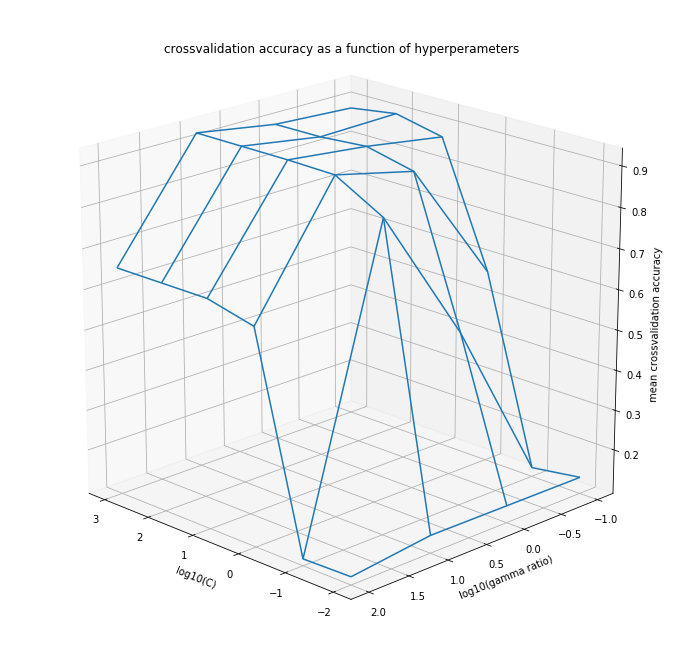

In [30]:
#Affichage de la précision sous forme de graphique:

from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')#, xscale="log", yscale="log")

ax.plot_wireframe(np.log10(cScale.reshape(-1,1)),
                  np.log10(gammaScale.reshape(1,-1) * X_sub.shape[1]),
                  scoreGrid),

ax.view_init(20,135)
ax.set_xlabel("log10(C)")
ax.set_ylabel("log10(gamma ratio)")
ax.set_zlabel("mean crossvalidation accuracy");
plt.title("crossvalidation accuracy as a function of hyperperameters");


#### Conclusion
The two most promising classifiers, after training on a small subset, are the RBF kernel SVM both on raw data and after PCA. They give a similar score on the cross-validation set, both slightly above 96% accuracy. For the next step, the PCA + RBF kernel SVM will be used

## Cross-validation on the full training set
### PCA + RBF kernel SVM

The PCA + RBF SVM parameters are adjusted in order to be trained on the full train set.

The model is fit on the 50000 first images of the dataset and tested on the 10000 last ones. A hill climb was done, manually changing the parameters until a minimum error rate of 1.36% was achieved.

In [31]:
args = {"C":1e4,"gamma":100/ X_pca_sub.shape[0]}
svc = svm.SVC(kernel = "rbf", class_weight="balanced", **args)
svc.fit(X_pca_subbig,y_subbig);

In [32]:
svc.score(X_pca_cvbig,y_cvbig)

0.9864

In [33]:
final_C = 1e4
final_gamma=100/ X_pca_sub.shape[0]
final_gamma

0.05

Hill climb:

{"C":1,"gamma":10 / X_pca_subbig.shape[0]} => 91.49%

{"C":10,"gamma":1 / X_pca_subbig.shape[0]} => 91.43%

{"C":10,"gamma":1 / X_pca_sub.shape[0]} => 93.39%

{"C":100,"gamma":1 / X_pca_sub.shape[0]} => 96.22%

{"C":1000,"gamma":1 / X_pca_sub.shape[0]} => 97.90%

{"C":1e4,"gamma":1 / X_pca_sub.shape[0]} => 98.08%

{"C":1e5,"gamma":1 / X_pca_sub.shape[0]} => 97.77%

{"C":1e4,"gamma":10 / X_pca_sub.shape[0]} => 98.06%

{"C":1e4,"gamma":100 / X_pca_sub.shape[0]} => 98.64%

{"C":1e4,"gamma":1e3 / X_pca_sub.shape[0]} => too long to fit

{"C":3e3,"gamma":100 / X_pca_sub.shape[0]} => 98.64%

{"C":3e4,"gamma":100 / X_pca_sub.shape[0]} => 98.64%



The optimal paramters depend much on the size of the dataset, as they are ***very different*** for 2000 and 50000 training images.

## Application on test data
The classifier is finally trained on the full 60000 examples, and tested on 
Final parameters are:
- PCA with 40 components
- RBF SVC with C = 1e4 and gamma = 0.5

In [34]:
#Fit on the full train set
svc_rbf = svm.SVC(kernel="rbf", class_weight="balanced", C=final_C, gamma=final_gamma)
svc_rbf.fit(X_pca_full,y_train_full)

SVC(C=10000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [35]:
#Score on the full train set
rbf_score_train = svc_rbf.score(X_pca_full,y_train_full)
print(f"Gaussian kernel, score on train set: {rbf_score_train}")

Gaussian kernel, score on train set: 1.0


In [36]:
#Score on the test set
y_pred_rbf = svc_rbf.predict(X_pca_test)
rbf_score = (y_pred_rbf == y_test).mean()
print(f"Gaussian kernel, score on test set: {rbf_score}")

Gaussian kernel, score on test set: 0.9853


The SVM has been run with almost no regularization, so in the end the training set has been perfectly fitted. However, there is still about 1.5% classification error on the test set.

Confusion matrix plot function copied from Scikit Learn examples https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

***Confusion matrix for Gaussian kernel SVM***

Confusion matrix, without normalization
[[ 974    0    1    0    0    1    0    1    3    0]
 [   0 1130    2    1    0    0    0    0    1    1]
 [   5    0 1015    1    1    0    1    6    3    0]
 [   0    0    2  995    1    4    0    4    3    1]
 [   1    1    1    0  965    0    2    1    1   10]
 [   2    0    0    7    1  876    2    1    2    1]
 [   4    2    0    0    1    3  947    0    1    0]
 [   1    2    7    1    1    0    0 1006    1    9]
 [   2    0    1    3    0    2    1    2  960    3]
 [   2    2    0    6    7    2    1    3    1  985]]


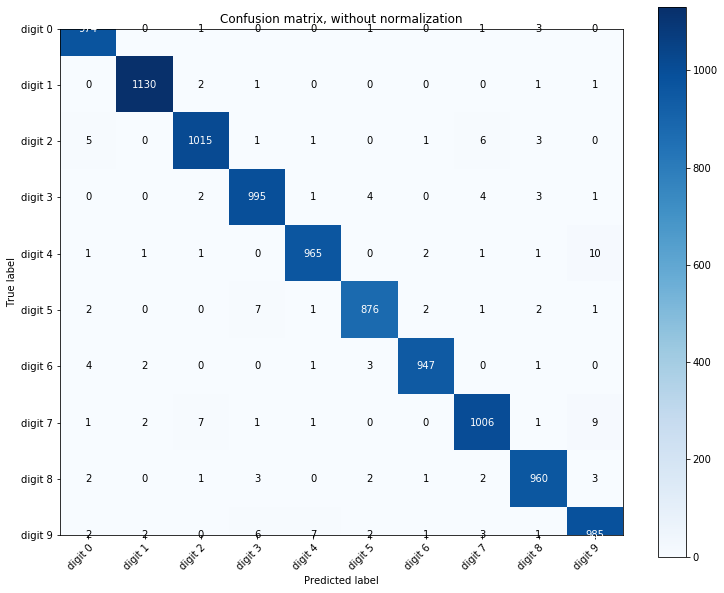

In [38]:
plot_confusion_matrix(y_test.astype('int'),
                      y_pred_rbf.astype('int'),
                      np.array(["digit %d"%ii for ii in range(10)]));
plt.gcf().set_size_inches(11, 11)

As expected, there is much confusion between digits 4 and 9.

Below is displayed a sample of 120 misclassified digits

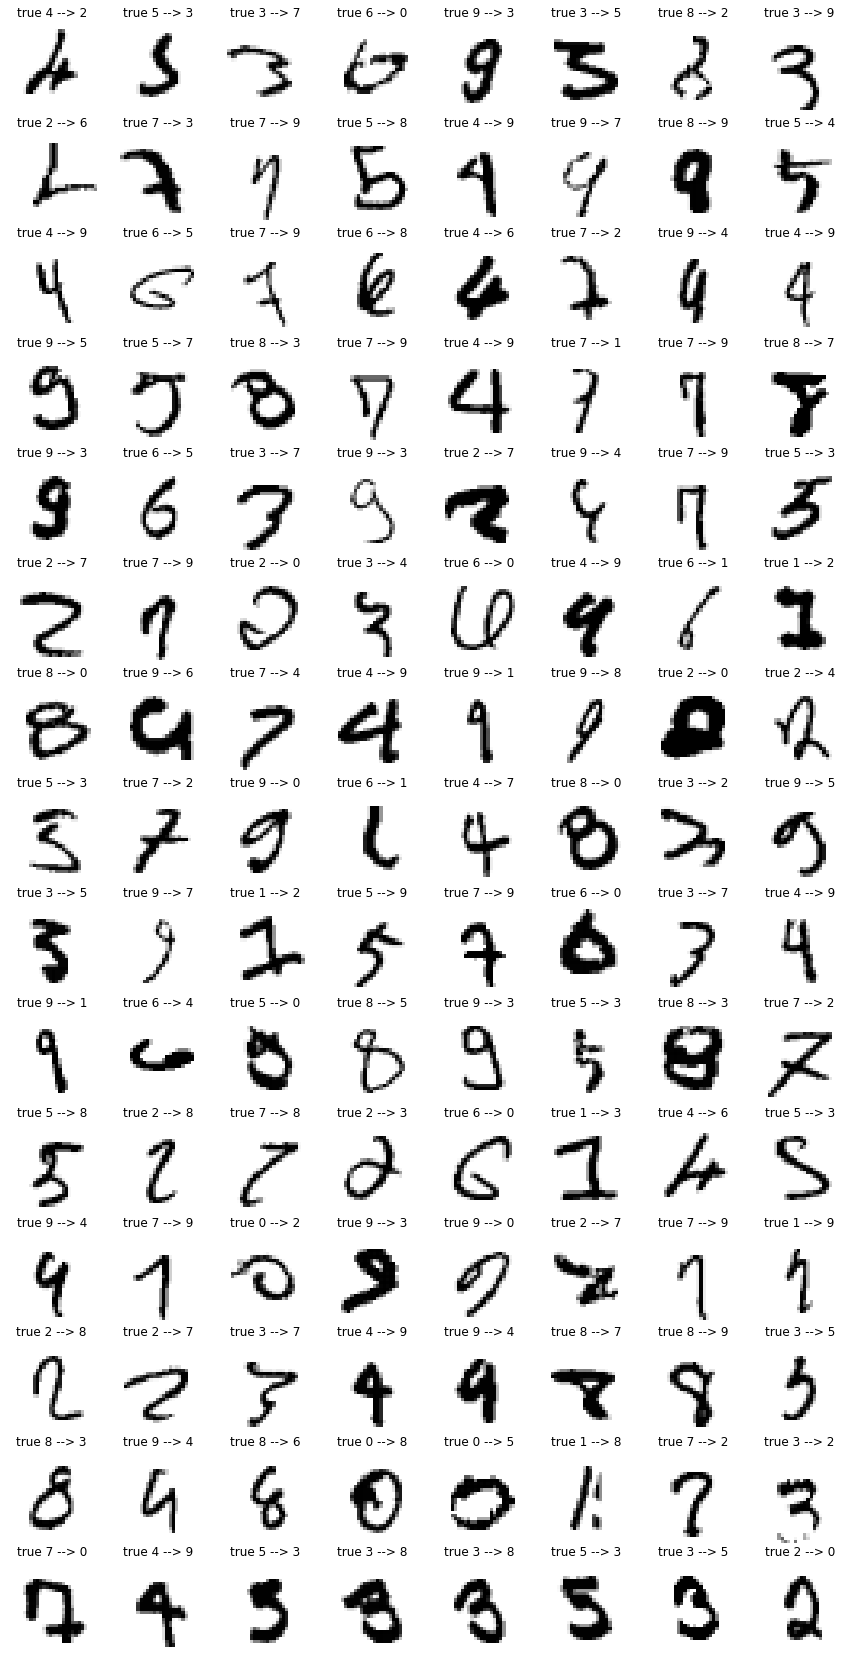

In [39]:
ind2plot = (y_pred_rbf != y_test).nonzero()[0][:120]

plt.figure(figsize=(15,30))
for ii,idx in enumerate(ind2plot):
    plt.subplot(15,8,ii+1);
    plt.imshow(X_test[idx,:].reshape(28,28),cmap='binary');
    plt.title('true %d --> %d'%(y_test[idx],y_pred_rbf[idx]))
    plt.axis('off')
    plt.axis('equal')

Some of the misclassified digits are poorly drawn and even a human would do mistakes classifying them. However, the classifier also seem sensitive to some minor variations of the script, such as drawing digit *7* with a bar, or simply using a thick pen. It would be interesting to further chech the confidence of the algorithm on the misclassified digits.